# Data Retrieval and Visualisation

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

In [2]:
# Connect to the SQLite database
conn = sqlite3.connect("Vaccinations.db")

# Create a dictionary to store DataFrames from each query
query_results = {}

### Task 1: Difference in administered vaccines between April and May 2022

In [3]:
query_d1 = '''
SELECT t1.month AS "OM1",
       t1.country_name AS "Country Name",
       t1.total_vaccinated AS "VOM1",
       t2.month AS "OM2",
       t2.total_vaccinated AS "VOM2",
       t1.total_vaccinated - t2.total_vaccinated AS "Difference"
FROM 
    (SELECT c2.country_name, month, 
            SUM(people_vaccinated + people_fully_vaccinated + total_booster) AS total_vaccinated 
     FROM country_vaccinated_record c1
     JOIN country_info c2 ON c1.iso_code = c2.iso_code
     WHERE year = 2022 AND month IN (4,5)
     GROUP BY c1.iso_code, month) t1       
JOIN
    (SELECT c2.country_name, month, 
            SUM(people_vaccinated + people_fully_vaccinated + total_booster) AS total_vaccinated 
     FROM country_vaccinated_record c1
     JOIN country_info c2 ON c1.iso_code = c2.iso_code
     WHERE year = 2022 AND month IN (4,5)
     GROUP BY c1.iso_code, month) t2
ON t1.country_name = t2.country_name
AND t1.month = 4
AND t2.month = 5;
'''
query_results['D1'] = pd.read_sql_query(query_d1, conn)

     OM1 Country Name         VOM1  OM2         VOM2  Difference
34     4        China  16301061000    5  13231695000  3069366000
162    4       Russia   2971157369    5   1887412467  1083744902
17     4   Bangladesh   2800780095    5   1820222624   980557471
40     4     Colombia    933653884    5    179329055   754324829
97     4     Cambodia    689084238    5     76096241   612987997
31     4       Canada   2397008330    5   1939401345   457606985
81     4      Hungary    284411719    5     83855381   200556338
153    4  Philippines    636211214    5    439574312   196636902
122    4      Myanmar    420814773    5    229002484   191812289
118    4       Mexico    981430136    5    792589628   188840508


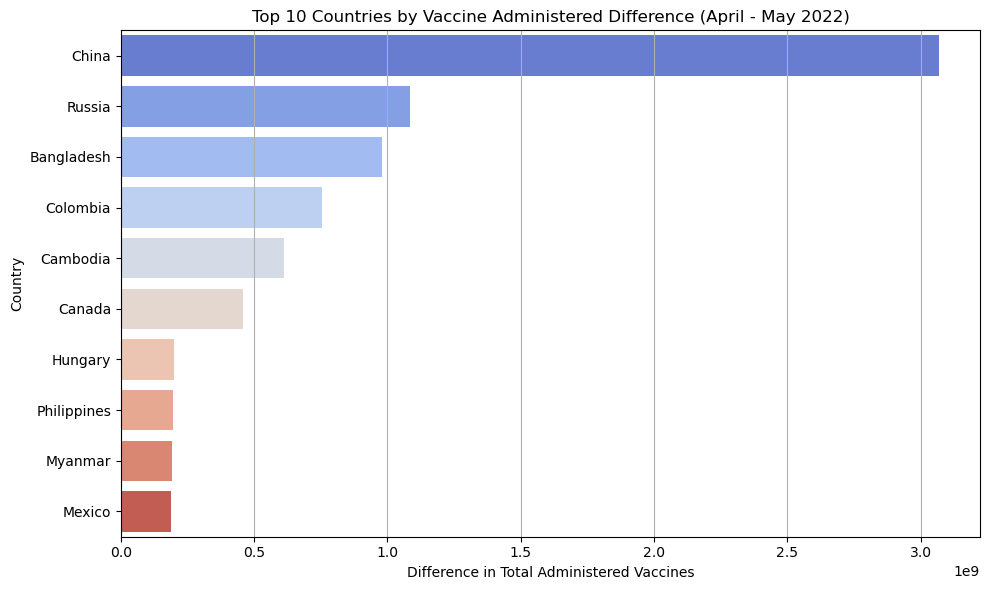

In [4]:
#========================= Visualize Task 1 =======================
plt.figure(figsize=(10, 6))
df_d1 = query_results['D1'].sort_values('Difference', ascending=False).head(10)
sns.barplot(data=df_d1, x='Difference', y='Country Name', palette='coolwarm')
plt.title("Top 10 Countries by Vaccine Administered Difference (April - May 2022)")
plt.xlabel("Difference in Total Administered Vaccines")
plt.ylabel("Country")
plt.tight_layout()
plt.grid(axis='x')

# Save plot
# plt.savefig("task1_top10_difference.png")

# Show plot and dataframe
print(df_d1)
plt.show()

### Task 2: Find countries with more than the average cumulative numbers of COVID-19 doses administered by each country in each month

In [5]:
query_d2 = '''
SELECT  c3.country_name AS "Country Name", 
        c1.month ||'/'|| c1.year AS "Month", mon_vac AS "Cumulative Doses"
FROM 
(
    SELECT iso_code, year, month,
           SUM(people_fully_vaccinated+people_vaccinated+total_booster) AS mon_vac      
    FROM country_vaccinated_record 
    GROUP BY iso_code, year, month    
) c1
LEFT OUTER JOIN
(
    SELECT iso_code, COUNT(month), 
           SUM(mon_vac) AS total_vac, 
           SUM(mon_vac)/COUNT(month) AS avg_vac     
    FROM (SELECT iso_code, year, month,
                 SUM(people_fully_vaccinated+people_vaccinated+total_booster) AS mon_vac      
          FROM country_vaccinated_record 
          GROUP BY iso_code, year, month) t1
    GROUP BY iso_code    
) c2
ON c1.iso_code = c2.iso_code
JOIN country_info c3
ON c1.iso_code = c3.iso_code AND c2.iso_code = c3.iso_code
WHERE mon_vac > avg_vac;
'''

query_results['D2'] = pd.read_sql_query(query_d2, conn)

  Country Name    Month  Cumulative Doses
0        Aruba   6/2021           3033279
1        Aruba   7/2021           3198996
2        Aruba   8/2021           3576155
3        Aruba   9/2021           3827175
4        Aruba  10/2021           3632515
5        Aruba  11/2021           4020918
6        Aruba  12/2021           3252953
7        Aruba   1/2022           3464953
8        Aruba   2/2022           3177419
9        Aruba   3/2022           4044727


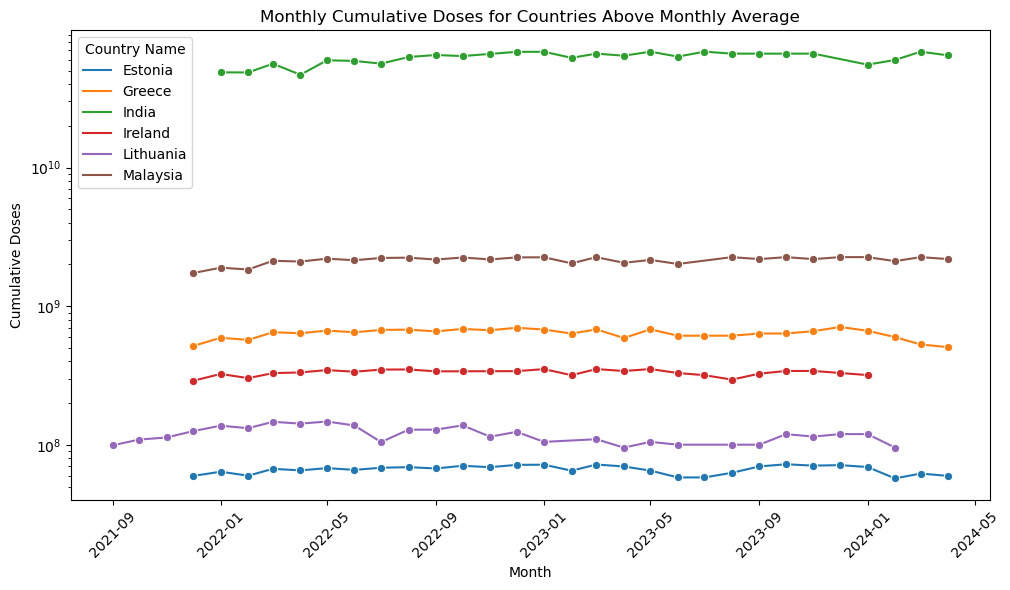

In [13]:
#========================= Visualize Task 2 ========================= 
df_d2 = pd.read_sql_query(query_d2, conn)

# Filter to top 6 most frequent countries
top_countries = df_d2['Country Name'].value_counts().nlargest(6).index
df_filtered = df_d2[df_d2['Country Name'].isin(top_countries)]

df_filtered = df_filtered.copy()
df_filtered["Date"] = pd.to_datetime(df_filtered["Month"], format="%m/%Y")

# Plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_filtered, x='Date', y='Cumulative Doses', hue='Country Name', marker='o')
plt.title("Monthly Cumulative Doses for Countries Above Monthly Average")
plt.xlabel("Month")
plt.ylabel("Cumulative Doses")
plt.xticks(rotation=45)
plt.tight_layout()

# Save plot
# plt.savefig("task2_cumulative_doses.png")

# Display dataframe to user
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

print(df_d2.head(10))
plt.yscale("log")
plt.show()

### Task 3: List vaccine types with the countries taking each vaccine type

In [7]:
query_d3 = '''
SELECT vaccine_brand AS "Vaccine Type",
       location AS "Country"
FROM vaccinations_by_manufacturer
GROUP BY location, vaccine_brand
ORDER BY vaccine_brand;
'''
query_results['D3'] = pd.read_sql_query(query_d3, conn)


  Vaccine Type         Country
0      CanSino       Argentina
1      CanSino         Ecuador
2      Covaxin         Czechia
3      Covaxin  European Union
4      Covaxin        Portugal


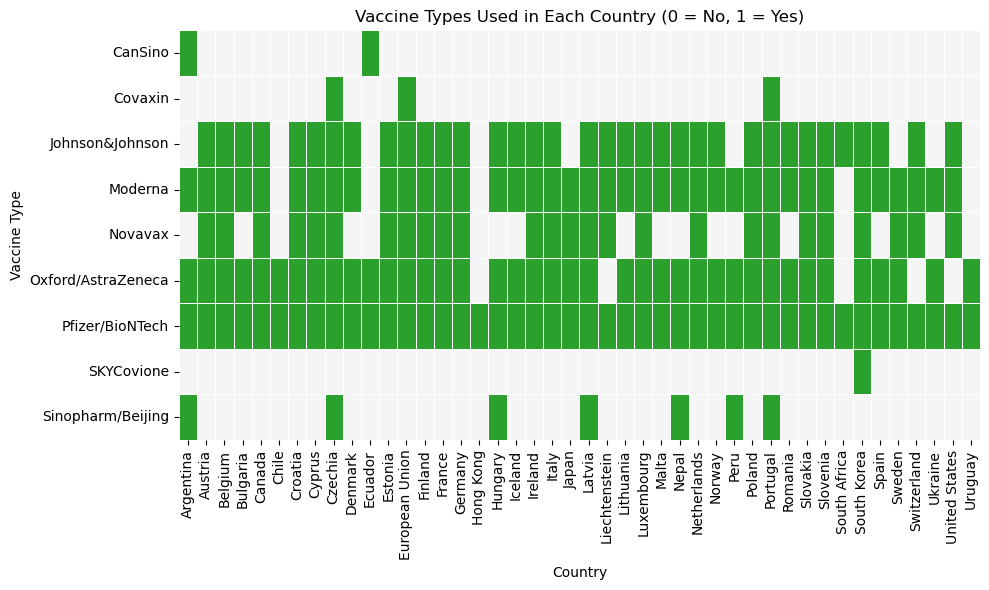

In [8]:
#=========================  Visualize Task 3 ========================= 

# add label
df_d3 = query_results['D3'].copy()
df_d3["Used"] = 1

# pivot table
pivot = df_d3.pivot_table(index="Vaccine Type", columns="Country", values="Used", fill_value=0)

# heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pivot, cmap=sns.color_palette(["#f5f5f5", "#2ca02c"]), linewidths=0.5, cbar=False)
plt.title("Vaccine Types Used in Each Country (0 = No, 1 = Yes)")
plt.xlabel("Country")
plt.ylabel("Vaccine Type")
plt.tight_layout()

# Save plot
#plt.savefig("task3_vaccine_type_heatmap.png")

#print
print(query_results['D3'].head())
plt.show()


### Task 4: Report showing the total number of vaccines administered in each country according to each data source

In [9]:
query_d4 = '''
SELECT c1.country_name AS [Country Name],
       c2.source_url AS [Source Name (URL)],
       [Total Administered Vaccines]
FROM country_info c1
JOIN country_source c2 ON c1.iso_code = c2.iso_code
JOIN (
    SELECT iso_code,
           SUM(people_fully_vaccinated + people_vaccinated + total_booster) AS [Total Administered Vaccines]
    FROM country_vaccinated_record
    GROUP BY iso_code
) c3 ON c1.iso_code = c3.iso_code
ORDER BY [Total Administered Vaccines];
'''
query_results['D4'] = pd.read_sql_query(query_d4, conn)

       Country Name                                  Source Name (URL)  \
0          Pitcairn  https://stats.pacificdata.org/vis?tm=covid&pg=...   
1  Falkland Islands  https://www.facebook.com/FalkIandsGov/posts/44...   
2              Niue           https://data.who.int/dashboards/covid19/   
3           Tokelau  https://stats.pacificdata.org/vis?tm=covid&pg=...   
4      Saint Helena  https://www.sainthelena.gov.sh/2021/news/preli...   

   Total Administered Vaccines  
0                          465  
1                        14163  
2                        17987  
3                        18977  
4                        24233  


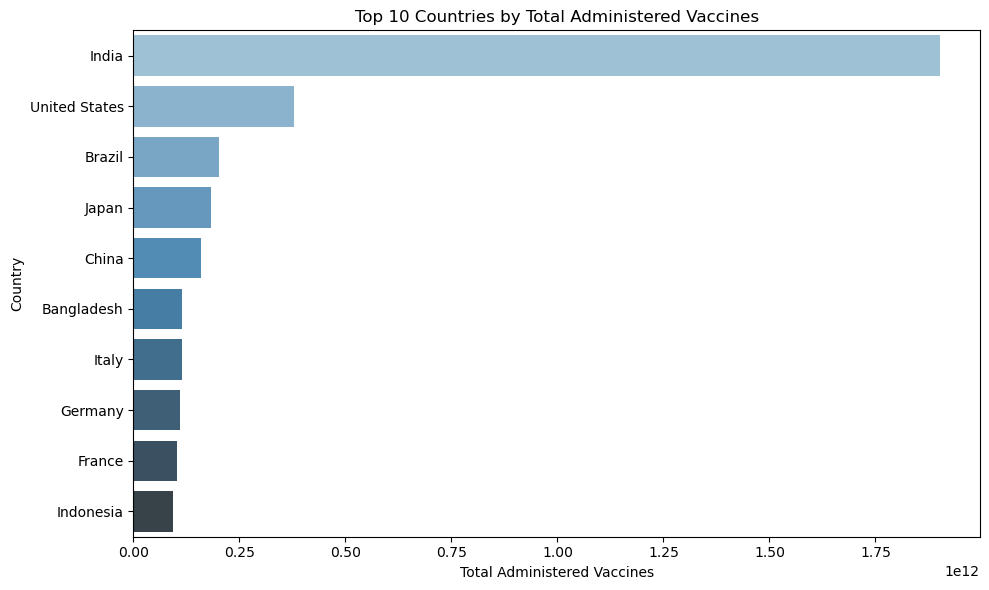

In [10]:
#=========================  Visualize Task 4 ========================= 
df_d4 = query_results['D4'].copy()

#select top 20 countries by total adminisered vaccines
df_sorted = df_d4.sort_values("Total Administered Vaccines", ascending=False).head(10)

# plot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_sorted,
    x="Total Administered Vaccines",
    y="Country Name",
    palette="Blues_d"
)
plt.title("Top 10 Countries by Total Administered Vaccines")
plt.xlabel("Total Administered Vaccines")
plt.ylabel("Country")
plt.tight_layout()

# Save plot
# plt.savefig("task4_top10_total_administered.png")

#print
print(df_d4.head())
plt.show()

### Task 5: List all the observation months in 2022 and 2023, and for each month, list the total number of people fully vaccinated in selected countries

In [11]:
query_d5 = '''
SELECT 
    month ||'/'|| year AS "Date Range (Months)",
    MAX(CASE WHEN country_name = 'United States' THEN num ELSE NULL END) AS "United States",
    MAX(CASE WHEN country_name = 'Wales' THEN num ELSE NULL END) AS "Wales",
    MAX(CASE WHEN country_name = 'Canada' THEN num ELSE NULL END) AS "Canada",
    MAX(CASE WHEN country_name = 'Denmark' THEN num ELSE NULL END) AS "Denmark"
FROM 
(
    SELECT c2.country_name, year, month, SUM(people_fully_vaccinated) AS num
    FROM country_vaccinated_record c1
    JOIN country_info c2 ON c1.iso_code = c2.iso_code
    WHERE year IN ('2022', '2023')
      AND c1.iso_code IN ('CAN','USA', 'OWID_WLS','DNK')
    GROUP BY c1.iso_code, year, month    
) t
GROUP BY year, month;
'''
query_results['D5'] = pd.read_sql_query(query_d5, conn)

   Date Range (Months)  United States       Wales       Canada     Denmark
0               1/2022   6.600698e+09  72520299.0  921332759.0  18550648.0
1               2/2022   6.077230e+09  66583095.0  857165749.0  18751187.0
2               3/2022   6.795487e+09  74219507.0  962730585.0  18785873.0
3               4/2022   6.621916e+09  72215488.0  843766566.0  23500111.0
4               5/2022   6.884155e+09  72524729.0  972005756.0  18810542.0
5               6/2022   6.693230e+09  72722039.0  817146990.0  18820420.0
6               7/2022   6.942374e+09  75530280.0  818313846.0  23535589.0
7               8/2022   6.972177e+09  75960111.0  977097794.0  18832559.0
8               9/2022   6.774564e+09  73720387.0  946890386.0  23544253.0
9              10/2022   7.044515e+09  76343178.0  979956004.0  18838458.0
10             11/2022   6.854696e+09  71566403.0  918311330.0  18840992.0
11             12/2022   7.107966e+09  42009052.0  761178717.0  23553706.0
12              1/2023   

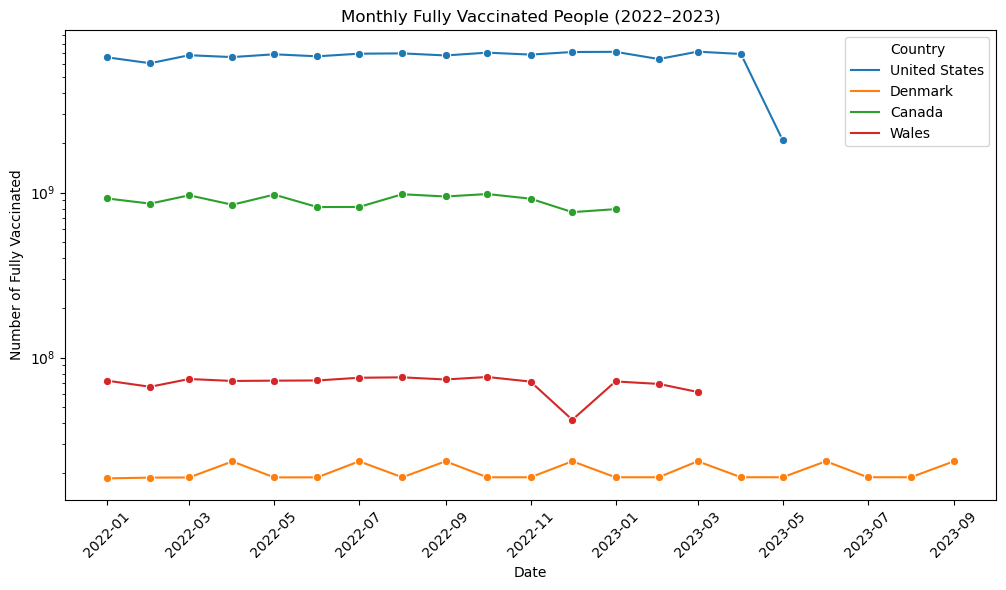

In [12]:
#=========================  Visualize Task 5 ========================= 
df_d5 = query_results['D5'].copy()

# change the data format
df_d5["Date"] = pd.to_datetime(df_d5["Date Range (Months)"], format="%m/%Y")

# build table
df_long = df_d5.melt(id_vars=["Date"], 
                     value_vars=["United States", "Wales", "Canada", "Denmark"],
                     var_name="Country", 
                     value_name="Fully Vaccinated")

# order the date
df_long = df_long.sort_values("Date")

# delete outliers (value > 0)
df_long = df_long[df_long["Fully Vaccinated"] > 0]

# plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_long, x="Date", y="Fully Vaccinated", hue="Country", marker="o")
plt.title("Monthly Fully Vaccinated People (2022–2023)")
plt.xlabel("Date")
plt.ylabel("Number of Fully Vaccinated")
plt.xticks(rotation=45)
plt.tight_layout()
plt.yscale("log")

# Save plot
#plt.savefig("task5_fully_vaccinated_trend.png")

# print
print(query_results['D5'])
plt.show()